In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import VarianceRatio
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('WindGeneration.csv')

In [3]:
s = ['01:00:00', 
     '02:00:00',
     '03:00:00',
     '04:00:00',
     '05:00:00',
     '06:00:00',
     '07:00:00',
     '08:00:00',
     '09:00:00',
     '10:00:00',
     '11:00:00',
     '12:00:00',
     '13:00:00',
     '14:00:00',
     '15:00:00',
     '16:00:00',
     '17:00:00', 
     '18:00:00',
     '19:00:00',
     '20:00:00','21:00:00',
     '22:00:00','23:00:00','00:00:00'] * 365
#Create Timestamps for the hour

In [4]:
df['Time'] = s #Add Timestamp to Time column

In [5]:
df['Date'] = df['Date'] + ' ' + df['Time'] #Add Timestamp to Date column

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S') #Convert to datetime

In [7]:
#Linearly interpolate for nans
df['Wind Generation'] = df['Wind Generation'].interpolate(method='linear', limit_direction='backward', axis=0) 

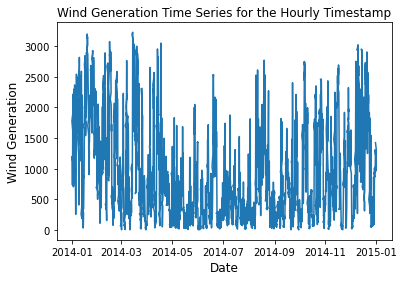

In [8]:
#Plot Wind Generation Time Series for the Hourly timestamp
plt.plot(df['Date'], df['Wind Generation'])
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title("Wind Generation Time Series for the Hourly Timestamp", fontsize=12) # Add title for the plot
plt.show()

In [9]:
daily_sample = df.resample('D', on='Date').sum() #Getting daily samples

In [10]:
weekly_sample = df.resample('W', on='Date').sum() #Getting weekly samples

In [11]:
monthly_sample = df.resample('M', on='Date').sum() #Getting monthly samples

In [12]:
quarterly_sample = df.resample('3M', on='Date').sum() #Getting quarterly samples

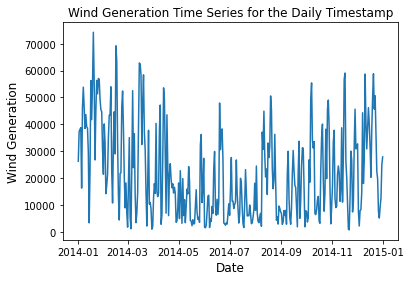

In [13]:
# Plotting the samples
plt.plot(daily_sample.index, daily_sample['Wind Generation'])
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title("Wind Generation Time Series for the Daily Timestamp", fontsize=12) # Add title for the plot
plt.show()

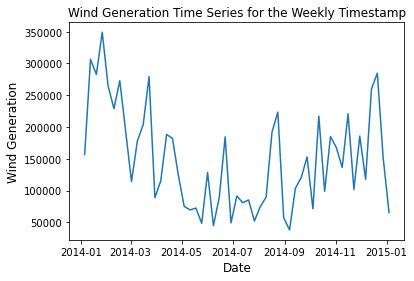

In [14]:
# Plotting the samples
plt.plot(weekly_sample.index, weekly_sample['Wind Generation'])
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title("Wind Generation Time Series for the Weekly Timestamp", fontsize=12) # Add title for the plot
plt.show()

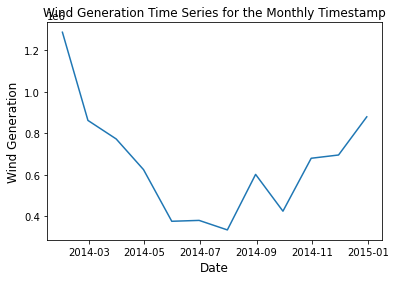

In [15]:
# Plotting the samples
plt.plot(monthly_sample.index, monthly_sample['Wind Generation'])
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title("Wind Generation Time Series for the Monthly Timestamp", fontsize=12) # Add title for the plot
plt.show()

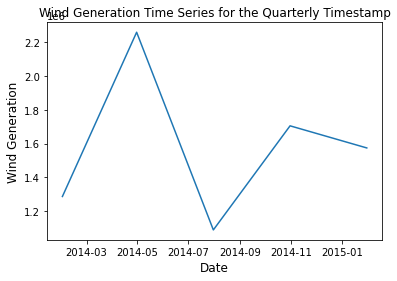

In [16]:
# Plotting the samples
plt.plot(quarterly_sample.index, quarterly_sample['Wind Generation'])
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title("Wind Generation Time Series for the Quarterly Timestamp", fontsize=12) # Add title for the plot
plt.show()

In [17]:
ss = list(df['Wind Generation']) # Convert wind generation to list
sd = [] # Initialize empty list to be filled in loop
for i in range(8759): # Start for loop to calculate the wind generation difference on an hourly basis
    s = ss[i+1]-ss[i] # Calculate difference 
    sd.append(s) # Fill up list
sd.append(0) # Add zero to end for synchronisation with date

In [18]:
a = max(df['Wind Generation']) #Get max value
b = min(df['Wind Generation']) # Get min value

In [19]:
diff = (np.array(sd)*100)/a #Convert to numpy array and get percentage given the largest value for wind generation

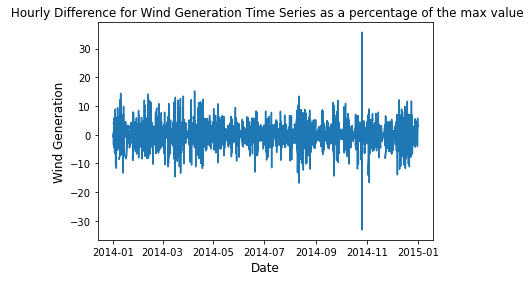

In [20]:
# Plotting the percentages
plt.plot(df['Date'], diff)
plt.xlabel('Date', fontsize=12) # Add label for x-axis
plt.ylabel('Wind Generation', fontsize=12) # Add label for y-axis
plt.title(" Hourly Difference for Wind Generation Time Series as a percentage of the max value", fontsize=12) # Add title for the plot
plt.show()


In [21]:
pos = [] #Empty list for positive ramps
neg = [] #Empty list for negative ramps
for i in diff:  #Loop over elements in series
    if i >= 0: #Getting the positives
        pos.append(i)
    else:          #Getting the negatives
        neg.append(i)
        

In [22]:
# Convert to numpy arrays
diff1 = np.abs(diff)
pos = np.array(pos) 
neg = np.array(neg)

In [23]:
#Get std from series
std = np.std(diff1)

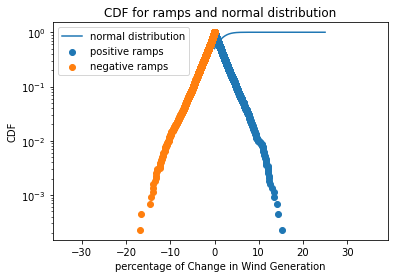

In [45]:
#Sort values
p = np.sort(pos)
n = np.sort(np.abs(neg))
diff1 = np.sort(diff1)
#calculate CDF values for series
cdfp = ECDF(p)
cdfn = ECDF(n)

plt.scatter(cdfp.x, 1-cdfp.y, label="positive ramps")
plt.scatter(-cdfn.x, 1-cdfn.y, label="negative ramps")

cdfnorm = scipy.stats.norm.cdf(diff1, 0, std)
#plot CDFs
plt.plot(diff1, cdfnorm, label = 'normal distribution')
plt.yscale('log')
plt.xlabel('percentage of Change in Wind Generation')
plt.ylabel("CDF")
plt.title("CDF for ramps and normal distribution")
plt.legend()
plt.show()

In [29]:
var = np.arange(1,25) #Labels for each period
one = []  # 1% percentile initiation
five = [] # 5% percentile initiation
ninetyfive = [] # 95% percentile initiation
ninetynine = [] # 99% percentile initiation
pad = [0] * 24 #padding so values after the last element won't break the loop
sss = ss + pad 
for i in range(1, 25):  #For loop to aggregate samples
    vs = []                #Initialize sampling
    for j in range(8759):  # For loop for difference
        idx = i + j
        f = sss[idx]
        l = sss[j]
        v = l - f
        vs.append(v)
    vs_arr = np.array(vs)    #Converting to numpy array
    #Getting percentiles through numpy
    one.append(np.percentile(vs_arr, 1))      
    five.append(np.percentile(vs_arr, 5))
    ninetyfive.append(np.percentile(vs_arr, 95))
    ninetynine.append(np.percentile(vs_arr, 99))

In [30]:
#Converting to numpy arrays
one = np.array(one)
five = np.array(five)
ninetyfive = np.array(ninetyfive)
ninetynine = np.array(ninetynine)


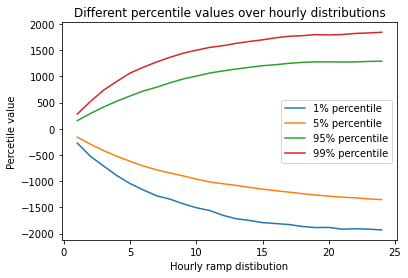

In [31]:
#Plotting the percentiles
plt.plot(var,one, label='1% percentile')
plt.plot(var,five, label='5% percentile')
plt.plot(var, ninetyfive, label='95% percentile')
plt.plot(var, ninetynine, label='99% percentile')
plt.xlabel("Hourly ramp distibution")
plt.ylabel("Percetile value")
plt.title("Different percentile values over hourly distributions")
plt.legend()
plt.show()

In [32]:
#Getting autocorrelation (lags are minus 1 bc the model counts from 0)
atf= statsmodels.tsa.stattools.acf(df['Wind Generation'], nlags = 239) 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


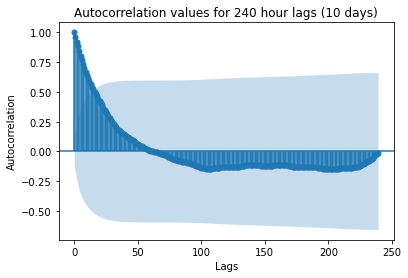

In [33]:
#Plotting autocorrelations
plot_acf(atf, lags=239, title="Autocorrelation values for 240 hour lags (10 days)")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

In [34]:
#Autocorrelation with confidence interval alpha(p) = 0.05
atf2= statsmodels.tsa.stattools.acf(df['Wind Generation'], nlags = 239, alpha = 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


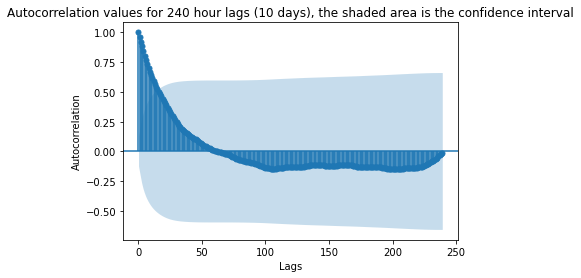

In [35]:
plot_acf(atf2[0], lags=239, title="Autocorrelation values for 240 hour lags (10 days), the shaded area is the confidence interval")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

In [36]:
df['Diff'] = diff

In [37]:
#Autocorrelation for change percentages with confidence interval alpha(p) = 0.05
atf3= statsmodels.tsa.stattools.acf(df['Diff'], nlags = 239, alpha = 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


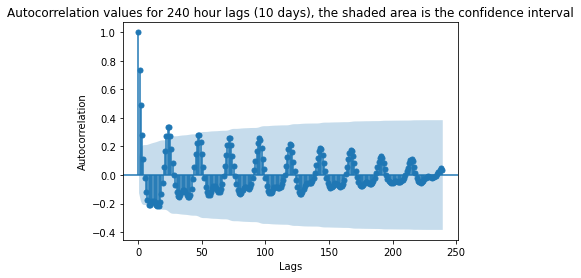

In [38]:
#Plotting for the percentages
plot_acf(atf3[0], lags=239, title="Autocorrelation values for 240 hour lags (10 days), the shaded area is the confidence interval")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

In [39]:
#Getting varaince ratio test
vr = VarianceRatio(df['Wind Generation'], 240)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                 -2.558
P-value                         0.011
Lags                              240
-------------------------------------

Computed with overlapping blocks (de-biased)


In [40]:
#Performing ADFULLER test for stationary determination
adf = statsmodels.tsa.stattools.adfuller(np.array(df['Wind Generation']),240)
print(adf)

(-5.132624008595446, 1.204900563242552e-05, 128, 8631, {'1%': -3.4311078781040734, '5%': -2.861874931189293, '10%': -2.56694827893115}, 95765.04197741301)


In [41]:
#Calculating MAEs for a moving average model
errs = []
for i in range(2, 26):  #since the 1 hour window using rolling results in the same model, we start from 2 and end at 25
    avg = df['Wind Generation'].rolling(i, min_periods = 1, center = True).sum()/i
    mae = sklearn.metrics.mean_absolute_error(df['Wind Generation'], avg)
    errs.append(mae)
print(errs)

[33.31454337899543, 15.881206240487062, 37.662585616438356, 32.50225799086758, 48.660962709284625, 49.748767123287664, 63.012384417808214, 66.925466768138, 78.44479337899543, 83.7968285595683, 94.21843892694064, 100.38608623112047, 109.87330316373125, 116.36246803652968, 125.06727026255706, 131.4966599516519, 139.62608574327754, 145.89465813506368, 153.54960901826485, 159.66873450750165, 166.8183696554587, 172.7436852293032, 179.38250903729073, 185.0499324200913]


In [42]:
errs = []  #Getting the forecasting model over horizons from 1 to 24
af = list(df['Wind Generation'])
for i in range(1, 25):
    vs = []
    for j in range(8760):
        cond = j - i
        if cond < 0:
            v = af[j]
        else:
            v = af[i-j]
        vs.append(v)
    mae = sklearn.metrics.mean_absolute_error(af, vs) #Getting the MAEs for the models
    errs.append(mae)
print(errs)

[774.0311301369863, 772.1473515981735, 770.2953652968037, 768.8288926940639, 767.9283789954337, 768.3237557077625, 769.2067694063927, 769.6953652968037, 770.1950799086759, 770.5044863013699, 770.8211986301369, 771.0114611872146, 770.8957534246575, 770.5149885844748, 769.8277968036529, 769.0950228310502, 768.8365296803653, 768.5509589041095, 768.1046689497716, 766.7187785388128, 765.1458675799087, 762.8441780821918, 760.32151826484, 757.9792237442922]


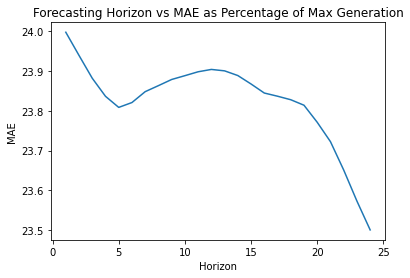

In [43]:
#Now we calculate the erros as percentage of maximum generation and plot them 
yss = (np.array(errs)*100)/a
xss = np.arange(1,25)
plt.plot(xss, yss)
plt.xlabel('Horizon')
plt.ylabel('MAE')
plt.title('Forecasting Horizon vs MAE as Percentage of Max Generation')
plt.show()

In [336]:
#Now we perform grid search to find optimal parameters for the model
ps = [0, 1, 2, 3, 4]
ds = [0, 1, 2 , 3]
qs = [0, 1, 2, 3]
best_aibi = 1000000000000
#Going over all possible combinations 
for i in ps:
    for j in ds:
        for k in qs:
            model = ARIMA(df['Wind Generation'], order=(i,j,k))   #Constructing the model
            fitted = model.fit()            #Fitting the model
            score = fitted.aic + fitted.bic         #Getting AIC and BIC
            if score < best_aibi:
                best_aibi = score         #Updating best score 
                best_params = (i, j, k)     #Updating best parameter vals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model

In [337]:
print(best_params)

(3, 1, 1)
